# FMLIKH Model: Large Amplitude Oscillatory Shear (LAOS)

## Protocol-Specific Context (Multi-Mode)

**FMLIKH LAOS** combines **multi-mode yielding** with **fractional memory** under large-amplitude oscillation:

1. **Intra-cycle multi-mode evolution**: Each $\lambda_i(t)$ changes within cycles via $D_t^{\alpha_i} \lambda_i$
2. **Distributed yielding**: Fast modes yield early in cycle, slow modes resist longer
3. **Rich harmonic content**: Each mode contributes harmonics with power-law decay $I_{n,i} \sim n^{-\alpha_i}$

**Why this matters**: Single-mode LAOS shows one yielding event per cycle. FMLIKH with N=3 can show **multiple intra-cycle yielding events** as successive structural levels break under oscillatory strain. This produces complex Lissajous figures and harmonic spectra that match experimental LAOS of hierarchical materials.

> **Physical insight**: During LAOS, fast modes break/reform rapidly within each cycle (high-frequency response). Slow modes persist across cycles (low-frequency envelope). Fractional kinetics smooths transitions, producing distinct harmonic signatures.

> **Handbook:** See [FMLIKH Documentation](../../docs/source/models/fikh/fmlikh.rst) for multi-mode LAOS harmonics and Lissajous interpretation.

## Learning Objectives

1. Simulate FMLIKH LAOS with N=3 modes
2. Analyze Lissajous figures showing multi-mode yielding
3. Extract harmonics and observe mode-specific power-law decay
4. Compare FMLIKH vs single-mode FIKH LAOS response
5. Understand intra-cycle structure evolution for each mode

## Prerequisites

- NB07: FMLIKH flow curve
- NB06: FIKH LAOS (single-mode baseline)

**Estimated Time:** 5-8 minutes (fast), 20-30 minutes (full)

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import os
import sys
import time
import warnings

# Robust path resolution for execution from any directory
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    compute_fit_quality,
    get_fmlikh_param_names,
    load_pnas_laos,
    print_convergence_summary,
    save_fikh_results,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# ============================================================
# FAST_MODE Configuration
# ============================================================
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    print("Running in FAST_MODE - reduced samples for quick validation")
    DOWNSAMPLE_FACTOR = 4  # Use every 4th data point
    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 100, 200, 1
else:
    print("Running in FULL mode - complete Bayesian inference")
    DOWNSAMPLE_FACTOR = 1  # Use all data
    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 200, 500, 1

Running in FAST_MODE - reduced samples for quick validation


## 2. Load Data

In [3]:
OMEGA = 1.0
STRAIN_AMP_INDEX = 5

time_raw, strain_raw, stress_raw = load_pnas_laos(omega=OMEGA, strain_amplitude_index=STRAIN_AMP_INDEX)

# Apply downsampling for FAST_MODE
if DOWNSAMPLE_FACTOR > 1:
    time_data = time_raw[::DOWNSAMPLE_FACTOR]
    strain_data = strain_raw[::DOWNSAMPLE_FACTOR]
    stress_data = stress_raw[::DOWNSAMPLE_FACTOR]
    print(f"Downsampled {len(time_raw)} -> {len(time_data)} points (factor {DOWNSAMPLE_FACTOR}x)")
else:
    time_data, strain_data, stress_data = time_raw, strain_raw, stress_raw

gamma_0 = (np.max(strain_data) - np.min(strain_data)) / 2

print(f"Data points: {len(time_data)}")
print(f"Strain amplitude: {gamma_0:.4f}")

Downsampled 1000 -> 250 points (factor 4x)
Data points: 250
Strain amplitude: 0.5120


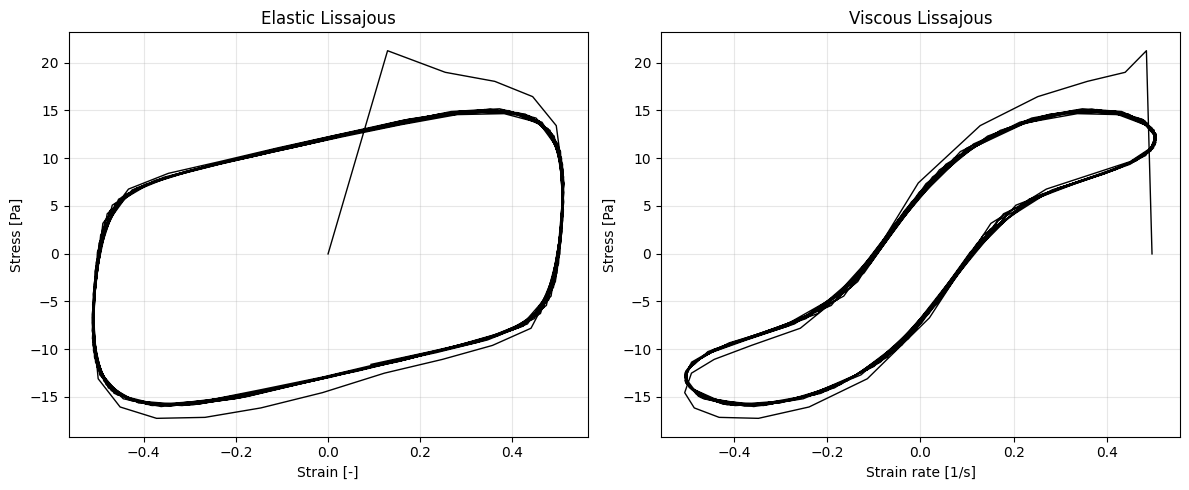

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(strain_data, stress_data, "k-", lw=1)
ax1.set_xlabel("Strain [-]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Elastic Lissajous")
ax1.grid(True, alpha=0.3)

gamma_dot_data = np.gradient(strain_data, time_data)
ax2.plot(gamma_dot_data, stress_data, "k-", lw=1)
ax2.set_xlabel("Strain rate [1/s]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title("Viscous Lissajous")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 3. NLSQ Fitting

In [5]:
# Number of modes: reduced in FAST_MODE for speed
N_MODES = 2 if FAST_MODE else 3
print(f"Using {N_MODES} modes (FAST_MODE={FAST_MODE})")

model = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.7)

t0 = time.time()
model.fit(time_data, stress_data, test_mode="laos", strain=strain_data, method='scipy')
print(f"NLSQ time: {time.time() - t0:.2f} s")

# Predict
laos_result = model.predict(time_data, test_mode="laos", strain=strain_data)
stress_pred = np.asarray(laos_result)
metrics = compute_fit_quality(stress_data, stress_pred)
print(f"R² = {metrics['R2']:.6f}")

Using 2 modes (FAST_MODE=True)


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fmlikh.py", line 561, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ time: 0.53 s
R² = -7.833702


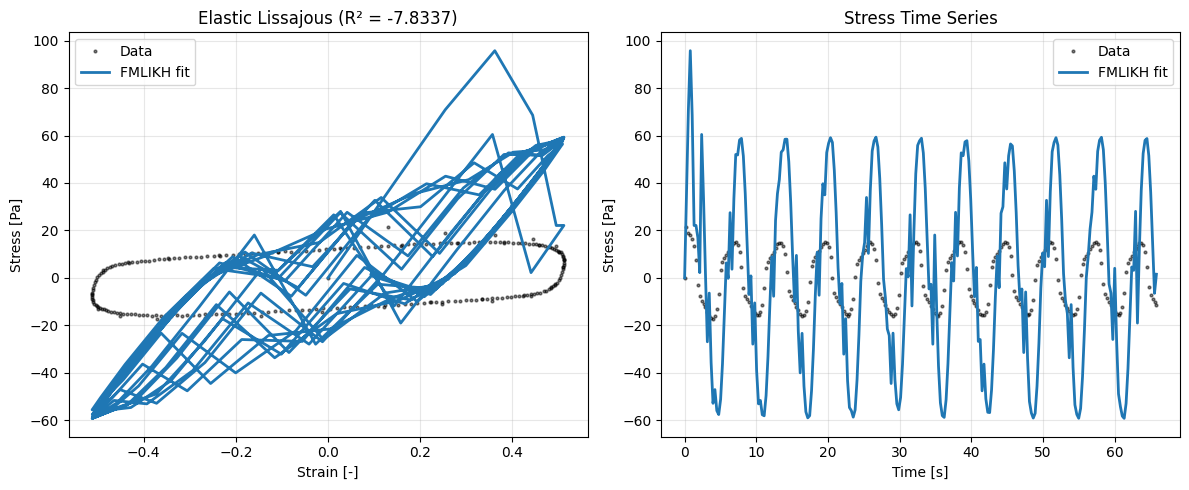

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(strain_data, stress_data, "ko", markersize=2, alpha=0.5, label="Data")
ax1.plot(strain_data, stress_pred, "-", lw=2, color="C0", label="FMLIKH fit")
ax1.set_xlabel("Strain [-]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title(f"Elastic Lissajous (R² = {metrics['R2']:.4f})")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(time_data, stress_data, "ko", markersize=2, alpha=0.5, label="Data")
ax2.plot(time_data, stress_pred, "-", lw=2, color="C0", label="FMLIKH fit")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title("Stress Time Series")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Bayesian Inference

In [7]:
param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)
initial_values = {n: model.parameters.get_value(n) for n in param_names if n in model.parameters}

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
print(f"  FAST_MODE={FAST_MODE}, N_MODES={N_MODES}, data points={len(time_data)}")

t0 = time.time()
result = model.fit_bayesian(
    time_data, stress_data, test_mode="laos", strain=strain_data,
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
t_bayes = time.time() - t0
print(f"Bayesian time: {t_bayes:.1f} s")

Running NUTS: 100 warmup + 200 samples x 1 chain(s)
  FAST_MODE=True, N_MODES=2, data points=250


  0%|          | 0/300 [00:00<?, ?it/s]

warmup:   0%|          | 1/300 [00:02<10:02,  2.02s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   3%|▎         | 9/300 [00:02<01:02,  4.63it/s, 215 steps of size 1.97e-10. acc. prob=0.03]

warmup:   4%|▎         | 11/300 [00:03<01:24,  3.43it/s, 255 steps of size 3.63e-10. acc. prob=0.21]

warmup:   4%|▍         | 12/300 [00:04<01:41,  2.84it/s, 255 steps of size 5.27e-10. acc. prob=0.27]

warmup:   4%|▍         | 13/300 [00:04<01:49,  2.62it/s, 255 steps of size 7.95e-10. acc. prob=0.33]

warmup:   5%|▍         | 14/300 [00:05<01:57,  2.44it/s, 255 steps of size 1.01e-09. acc. prob=0.37]

warmup:   5%|▌         | 15/300 [00:05<02:03,  2.31it/s, 255 steps of size 1.46e-09. acc. prob=0.41]

warmup:   5%|▌         | 16/300 [00:06<01:59,  2.38it/s, 186 steps of size 2.42e-10. acc. prob=0.40]

warmup:   6%|▌         | 17/300 [00:06<02:05,  2.25it/s, 255 steps of size 3.93e-10. acc. prob=0.44]

warmup:   6%|▌         | 18/300 [00:07<02:10,  2.16it/s, 255 steps of size 6.15e-10. acc. prob=0.47]

warmup:   6%|▋         | 19/300 [00:07<02:14,  2.09it/s, 255 steps of size 9.54e-10. acc. prob=0.50]

warmup:   7%|▋         | 20/300 [00:08<02:16,  2.05it/s, 255 steps of size 1.55e-09. acc. prob=0.52]

warmup:   7%|▋         | 21/300 [00:08<02:18,  2.02it/s, 255 steps of size 2.19e-09. acc. prob=0.54]

warmup:   8%|▊         | 23/300 [00:09<01:48,  2.56it/s, 255 steps of size 3.08e-10. acc. prob=0.54]

warmup:   8%|▊         | 24/300 [00:09<01:56,  2.37it/s, 255 steps of size 4.91e-10. acc. prob=0.56]

warmup:   8%|▊         | 25/300 [00:10<02:02,  2.24it/s, 255 steps of size 7.98e-10. acc. prob=0.57]

warmup:   9%|▊         | 26/300 [00:10<02:07,  2.15it/s, 255 steps of size 1.17e-09. acc. prob=0.59]

warmup:   9%|▉         | 27/300 [00:11<02:10,  2.09it/s, 255 steps of size 5.61e-10. acc. prob=0.59]

warmup:   9%|▉         | 28/300 [00:11<02:13,  2.04it/s, 255 steps of size 5.19e-10. acc. prob=0.60]

warmup:  10%|▉         | 29/300 [00:12<02:14,  2.01it/s, 255 steps of size 6.21e-10. acc. prob=0.61]

warmup:  10%|█         | 30/300 [00:12<02:15,  1.99it/s, 255 steps of size 9.63e-10. acc. prob=0.62]

warmup:  10%|█         | 31/300 [00:13<02:18,  1.94it/s, 255 steps of size 1.53e-09. acc. prob=0.63]

warmup:  11%|█         | 33/300 [00:13<01:47,  2.49it/s, 255 steps of size 2.57e-10. acc. prob=0.62]

warmup:  11%|█▏        | 34/300 [00:14<01:54,  2.32it/s, 255 steps of size 3.96e-10. acc. prob=0.63]

warmup:  12%|█▏        | 35/300 [00:15<02:02,  2.16it/s, 255 steps of size 6.23e-10. acc. prob=0.64]

warmup:  12%|█▏        | 36/300 [00:15<02:05,  2.10it/s, 255 steps of size 9.51e-10. acc. prob=0.65]

warmup:  12%|█▏        | 37/300 [00:16<02:08,  2.05it/s, 255 steps of size 8.36e-10. acc. prob=0.66]

warmup:  13%|█▎        | 38/300 [00:16<02:09,  2.02it/s, 255 steps of size 1.21e-09. acc. prob=0.67]

warmup:  13%|█▎        | 39/300 [00:17<02:11,  1.99it/s, 255 steps of size 4.85e-10. acc. prob=0.66]

warmup:  13%|█▎        | 40/300 [00:17<02:11,  1.97it/s, 255 steps of size 5.94e-10. acc. prob=0.67]

warmup:  14%|█▎        | 41/300 [00:18<02:12,  1.95it/s, 255 steps of size 8.10e-10. acc. prob=0.67]

warmup:  14%|█▍        | 42/300 [00:18<02:12,  1.95it/s, 255 steps of size 1.23e-09. acc. prob=0.68]

warmup:  14%|█▍        | 43/300 [00:19<02:12,  1.94it/s, 255 steps of size 1.21e-09. acc. prob=0.69]

warmup:  15%|█▍        | 44/300 [00:19<02:12,  1.94it/s, 255 steps of size 4.64e-10. acc. prob=0.68]

warmup:  15%|█▌        | 45/300 [00:20<02:12,  1.93it/s, 255 steps of size 6.86e-10. acc. prob=0.69]

warmup:  15%|█▌        | 46/300 [00:20<02:11,  1.93it/s, 255 steps of size 9.01e-10. acc. prob=0.69]

warmup:  16%|█▌        | 47/300 [00:21<02:11,  1.93it/s, 255 steps of size 1.32e-09. acc. prob=0.70]

warmup:  16%|█▌        | 48/300 [00:21<02:03,  2.04it/s, 210 steps of size 1.40e-09. acc. prob=0.70]

warmup:  16%|█▋        | 49/300 [00:21<01:50,  2.28it/s, 154 steps of size 1.57e-09. acc. prob=0.71]

warmup:  17%|█▋        | 50/300 [00:22<01:32,  2.71it/s, 100 steps of size 3.59e-10. acc. prob=0.70]

warmup:  17%|█▋        | 51/300 [00:22<01:42,  2.42it/s, 255 steps of size 5.07e-10. acc. prob=0.70]

warmup:  17%|█▋        | 52/300 [00:23<01:49,  2.26it/s, 255 steps of size 7.09e-10. acc. prob=0.71]

warmup:  18%|█▊        | 53/300 [00:23<01:55,  2.14it/s, 255 steps of size 8.39e-10. acc. prob=0.71]

warmup:  18%|█▊        | 54/300 [00:24<01:40,  2.45it/s, 131 steps of size 2.56e-10. acc. prob=0.70]

warmup:  18%|█▊        | 55/300 [00:24<01:48,  2.26it/s, 255 steps of size 3.74e-10. acc. prob=0.71]

warmup:  19%|█▊        | 56/300 [00:25<01:53,  2.14it/s, 255 steps of size 5.44e-10. acc. prob=0.71]

warmup:  19%|█▉        | 57/300 [00:25<01:57,  2.07it/s, 255 steps of size 7.51e-10. acc. prob=0.72]

warmup:  19%|█▉        | 58/300 [00:26<01:59,  2.03it/s, 255 steps of size 1.67e-10. acc. prob=0.71]

warmup:  20%|█▉        | 59/300 [00:26<02:01,  1.99it/s, 255 steps of size 2.41e-10. acc. prob=0.71]

warmup:  20%|██        | 60/300 [00:27<02:02,  1.97it/s, 255 steps of size 3.38e-10. acc. prob=0.72]

warmup:  20%|██        | 61/300 [00:27<02:02,  1.95it/s, 255 steps of size 4.85e-10. acc. prob=0.72]

warmup:  21%|██        | 62/300 [00:28<02:02,  1.95it/s, 255 steps of size 6.83e-10. acc. prob=0.73]

warmup:  21%|██        | 63/300 [00:28<02:01,  1.94it/s, 255 steps of size 9.71e-10. acc. prob=0.73]

warmup:  21%|██▏       | 64/300 [00:29<02:03,  1.92it/s, 255 steps of size 1.15e-09. acc. prob=0.73]

warmup:  22%|██▏       | 65/300 [00:29<02:02,  1.92it/s, 255 steps of size 7.56e-10. acc. prob=0.73]

warmup:  22%|██▏       | 66/300 [00:30<02:02,  1.92it/s, 255 steps of size 8.56e-10. acc. prob=0.74]

warmup:  22%|██▏       | 67/300 [00:30<02:01,  1.92it/s, 255 steps of size 1.18e-09. acc. prob=0.74]

warmup:  23%|██▎       | 68/300 [00:30<01:33,  2.48it/s, 61 steps of size 7.73e-10. acc. prob=0.74] 

warmup:  23%|██▎       | 69/300 [00:31<01:41,  2.28it/s, 255 steps of size 1.08e-09. acc. prob=0.74]

warmup:  23%|██▎       | 70/300 [00:31<01:47,  2.15it/s, 255 steps of size 1.27e-09. acc. prob=0.74]

warmup:  24%|██▎       | 71/300 [00:32<01:53,  2.02it/s, 235 steps of size 3.20e-10. acc. prob=0.74]

warmup:  24%|██▍       | 72/300 [00:33<01:54,  1.99it/s, 255 steps of size 4.22e-10. acc. prob=0.74]

warmup:  24%|██▍       | 73/300 [00:33<01:55,  1.97it/s, 255 steps of size 5.87e-10. acc. prob=0.74]

warmup:  25%|██▍       | 74/300 [00:34<01:55,  1.95it/s, 255 steps of size 6.97e-10. acc. prob=0.75]

warmup:  25%|██▌       | 75/300 [00:34<01:55,  1.94it/s, 255 steps of size 9.50e-10. acc. prob=0.75]

warmup:  25%|██▌       | 76/300 [00:35<01:56,  1.93it/s, 255 steps of size 1.30e-09. acc. prob=0.75]

warmup:  26%|██▌       | 78/300 [00:35<01:29,  2.48it/s, 255 steps of size 3.26e-10. acc. prob=0.75]

warmup:  26%|██▋       | 79/300 [00:36<01:35,  2.31it/s, 255 steps of size 4.48e-10. acc. prob=0.75]

warmup:  27%|██▋       | 80/300 [00:36<01:40,  2.20it/s, 255 steps of size 6.08e-10. acc. prob=0.75]

warmup:  27%|██▋       | 81/300 [00:37<01:44,  2.10it/s, 255 steps of size 6.99e-10. acc. prob=0.75]

warmup:  27%|██▋       | 82/300 [00:37<01:46,  2.04it/s, 255 steps of size 9.10e-10. acc. prob=0.76]

warmup:  28%|██▊       | 83/300 [00:38<01:47,  2.01it/s, 255 steps of size 8.27e-10. acc. prob=0.76]

warmup:  28%|██▊       | 84/300 [00:38<01:49,  1.97it/s, 255 steps of size 1.04e-09. acc. prob=0.76]

warmup:  29%|██▊       | 86/300 [00:39<01:25,  2.49it/s, 255 steps of size 3.24e-10. acc. prob=0.75]

warmup:  29%|██▉       | 87/300 [00:39<01:31,  2.32it/s, 255 steps of size 4.38e-10. acc. prob=0.76]

warmup:  29%|██▉       | 88/300 [00:40<01:36,  2.20it/s, 255 steps of size 5.91e-10. acc. prob=0.76]

warmup:  30%|██▉       | 89/300 [00:40<01:39,  2.12it/s, 255 steps of size 6.49e-10. acc. prob=0.76]

warmup:  30%|███       | 90/300 [00:41<01:41,  2.06it/s, 255 steps of size 8.68e-10. acc. prob=0.76]

warmup:  30%|███       | 91/300 [00:41<01:43,  2.02it/s, 255 steps of size 1.04e-08. acc. prob=0.77]

warmup:  31%|███       | 92/300 [00:42<01:44,  1.99it/s, 255 steps of size 1.38e-08. acc. prob=0.77]

warmup:  31%|███       | 93/300 [00:43<01:45,  1.95it/s, 255 steps of size 1.92e-08. acc. prob=0.77]

warmup:  31%|███▏      | 94/300 [00:43<01:45,  1.94it/s, 255 steps of size 2.70e-08. acc. prob=0.77]

warmup:  32%|███▏      | 95/300 [00:44<01:45,  1.94it/s, 255 steps of size 3.67e-08. acc. prob=0.78]

warmup:  32%|███▏      | 96/300 [00:44<01:45,  1.93it/s, 255 steps of size 5.12e-08. acc. prob=0.78]

warmup:  32%|███▏      | 97/300 [00:45<01:45,  1.92it/s, 255 steps of size 6.56e-08. acc. prob=0.78]

warmup:  33%|███▎      | 98/300 [00:45<01:45,  1.92it/s, 255 steps of size 9.12e-08. acc. prob=0.78]

warmup:  33%|███▎      | 99/300 [00:46<01:45,  1.91it/s, 255 steps of size 1.24e-07. acc. prob=0.79]

warmup:  33%|███▎      | 100/300 [00:46<01:49,  1.83it/s, 255 steps of size 6.34e-08. acc. prob=0.79]

sample:  34%|███▎      | 101/300 [00:47<01:50,  1.80it/s, 255 steps of size 6.34e-08. acc. prob=1.00]

sample:  34%|███▍      | 102/300 [00:47<01:47,  1.83it/s, 255 steps of size 6.34e-08. acc. prob=1.00]

sample:  34%|███▍      | 103/300 [00:48<01:47,  1.84it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  35%|███▍      | 104/300 [00:48<01:47,  1.82it/s, 255 steps of size 6.34e-08. acc. prob=0.97]

sample:  35%|███▌      | 105/300 [00:49<01:45,  1.85it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  35%|███▌      | 106/300 [00:50<01:43,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  36%|███▌      | 107/300 [00:50<01:42,  1.88it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  36%|███▌      | 108/300 [00:51<01:41,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  36%|███▋      | 109/300 [00:51<01:43,  1.85it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  37%|███▋      | 110/300 [00:52<01:42,  1.86it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  37%|███▋      | 111/300 [00:52<01:40,  1.88it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  37%|███▋      | 112/300 [00:53<01:39,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  38%|███▊      | 113/300 [00:53<01:40,  1.86it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  38%|███▊      | 114/300 [00:54<01:39,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  38%|███▊      | 115/300 [00:54<01:38,  1.88it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  39%|███▊      | 116/300 [00:55<01:37,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  39%|███▉      | 117/300 [00:55<01:36,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  39%|███▉      | 118/300 [00:56<01:35,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  40%|███▉      | 119/300 [00:56<01:34,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  40%|████      | 120/300 [00:57<01:34,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  40%|████      | 121/300 [00:57<01:34,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  41%|████      | 122/300 [00:58<01:33,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  41%|████      | 123/300 [00:59<01:33,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  41%|████▏     | 124/300 [00:59<01:32,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  42%|████▏     | 125/300 [01:00<01:31,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  42%|████▏     | 126/300 [01:00<01:31,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  42%|████▏     | 127/300 [01:01<01:30,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  43%|████▎     | 128/300 [01:01<01:29,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  43%|████▎     | 129/300 [01:02<01:29,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  43%|████▎     | 130/300 [01:02<01:29,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  44%|████▎     | 131/300 [01:03<01:28,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  44%|████▍     | 132/300 [01:03<01:27,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  44%|████▍     | 133/300 [01:04<01:27,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  45%|████▍     | 134/300 [01:04<01:26,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  45%|████▌     | 135/300 [01:05<01:26,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  45%|████▌     | 136/300 [01:05<01:26,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  46%|████▌     | 137/300 [01:06<01:25,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  46%|████▌     | 138/300 [01:06<01:24,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  46%|████▋     | 139/300 [01:07<01:24,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  47%|████▋     | 140/300 [01:07<01:23,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  47%|████▋     | 141/300 [01:08<01:24,  1.88it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  47%|████▋     | 142/300 [01:09<01:23,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  48%|████▊     | 143/300 [01:09<01:22,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  48%|████▊     | 144/300 [01:10<01:22,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  48%|████▊     | 145/300 [01:10<01:21,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  49%|████▊     | 146/300 [01:11<01:21,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  49%|████▉     | 147/300 [01:11<01:20,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  49%|████▉     | 148/300 [01:12<01:19,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  50%|████▉     | 149/300 [01:12<01:19,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  50%|█████     | 150/300 [01:13<01:18,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  50%|█████     | 151/300 [01:13<01:17,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  51%|█████     | 152/300 [01:14<01:17,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  51%|█████     | 153/300 [01:14<01:16,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.99]

sample:  51%|█████▏    | 154/300 [01:15<01:16,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  52%|█████▏    | 155/300 [01:15<01:16,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  52%|█████▏    | 156/300 [01:16<01:17,  1.85it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  52%|█████▏    | 157/300 [01:16<01:16,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  53%|█████▎    | 158/300 [01:17<01:15,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  53%|█████▎    | 159/300 [01:17<01:14,  1.88it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  53%|█████▎    | 160/300 [01:18<01:13,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  54%|█████▎    | 161/300 [01:19<01:13,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  54%|█████▍    | 162/300 [01:19<01:12,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  54%|█████▍    | 163/300 [01:20<01:11,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  55%|█████▍    | 164/300 [01:20<01:11,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  55%|█████▌    | 165/300 [01:21<01:14,  1.82it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  55%|█████▌    | 166/300 [01:21<01:13,  1.83it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  56%|█████▌    | 167/300 [01:22<01:11,  1.85it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  56%|█████▌    | 168/300 [01:22<01:11,  1.85it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  56%|█████▋    | 169/300 [01:23<01:10,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  57%|█████▋    | 170/300 [01:23<01:09,  1.88it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  57%|█████▋    | 171/300 [01:24<01:07,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  57%|█████▋    | 172/300 [01:24<01:07,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  58%|█████▊    | 173/300 [01:25<01:07,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  58%|█████▊    | 174/300 [01:25<01:06,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  58%|█████▊    | 175/300 [01:26<01:05,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  59%|█████▊    | 176/300 [01:26<01:05,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  59%|█████▉    | 177/300 [01:27<01:04,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  59%|█████▉    | 178/300 [01:28<01:04,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  60%|█████▉    | 179/300 [01:28<01:06,  1.83it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  60%|██████    | 180/300 [01:29<01:05,  1.83it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  60%|██████    | 181/300 [01:29<01:04,  1.85it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  61%|██████    | 182/300 [01:31<01:31,  1.29it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  61%|██████    | 183/300 [01:31<01:21,  1.43it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  61%|██████▏   | 184/300 [01:32<01:14,  1.55it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  62%|██████▏   | 185/300 [01:32<01:10,  1.63it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  62%|██████▏   | 186/300 [01:33<01:06,  1.71it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  62%|██████▏   | 187/300 [01:33<01:03,  1.77it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  63%|██████▎   | 188/300 [01:34<01:01,  1.81it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  63%|██████▎   | 189/300 [01:34<01:00,  1.84it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  63%|██████▎   | 190/300 [01:35<00:58,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  64%|██████▎   | 191/300 [01:35<00:57,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  64%|██████▍   | 192/300 [01:36<00:56,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  64%|██████▍   | 193/300 [01:36<00:56,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  65%|██████▍   | 194/300 [01:37<00:55,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  65%|██████▌   | 195/300 [01:37<00:54,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  65%|██████▌   | 196/300 [01:38<00:54,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  66%|██████▌   | 197/300 [01:38<00:54,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  66%|██████▌   | 198/300 [01:39<00:53,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  66%|██████▋   | 199/300 [01:39<00:53,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  67%|██████▋   | 200/300 [01:40<00:53,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  67%|██████▋   | 201/300 [01:41<00:52,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  67%|██████▋   | 202/300 [01:41<00:51,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  68%|██████▊   | 203/300 [01:42<00:50,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  68%|██████▊   | 204/300 [01:42<00:50,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  68%|██████▊   | 205/300 [01:43<00:49,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  69%|██████▊   | 206/300 [01:43<00:49,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  69%|██████▉   | 207/300 [01:44<00:48,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  69%|██████▉   | 208/300 [01:44<00:47,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  70%|██████▉   | 209/300 [01:45<00:47,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  70%|███████   | 210/300 [01:45<00:46,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  70%|███████   | 211/300 [01:46<00:46,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  71%|███████   | 212/300 [01:46<00:46,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  71%|███████   | 213/300 [01:47<00:45,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  71%|███████▏  | 214/300 [01:47<00:44,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  72%|███████▏  | 215/300 [01:48<00:44,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  72%|███████▏  | 216/300 [01:48<00:44,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  72%|███████▏  | 217/300 [01:49<00:44,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  73%|███████▎  | 218/300 [01:49<00:43,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  73%|███████▎  | 219/300 [01:50<00:42,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  73%|███████▎  | 220/300 [01:50<00:42,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  74%|███████▎  | 221/300 [01:51<00:41,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  74%|███████▍  | 222/300 [01:52<00:41,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  74%|███████▍  | 223/300 [01:52<00:40,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  75%|███████▍  | 224/300 [01:53<00:39,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  75%|███████▌  | 225/300 [01:53<00:39,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  75%|███████▌  | 226/300 [01:54<00:38,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  76%|███████▌  | 227/300 [01:54<00:38,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  76%|███████▌  | 228/300 [01:55<00:37,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  76%|███████▋  | 229/300 [01:55<00:37,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  77%|███████▋  | 230/300 [01:56<00:36,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  77%|███████▋  | 231/300 [01:56<00:35,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  77%|███████▋  | 232/300 [01:57<00:35,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  78%|███████▊  | 233/300 [01:57<00:36,  1.83it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  78%|███████▊  | 234/300 [01:58<00:35,  1.86it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  78%|███████▊  | 235/300 [01:58<00:34,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  79%|███████▊  | 236/300 [01:59<00:33,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  79%|███████▉  | 237/300 [01:59<00:33,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  79%|███████▉  | 238/300 [02:00<00:32,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  80%|███████▉  | 239/300 [02:00<00:31,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  80%|████████  | 240/300 [02:01<00:31,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  80%|████████  | 241/300 [02:02<00:30,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  81%|████████  | 242/300 [02:02<00:30,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  81%|████████  | 243/300 [02:03<00:29,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  81%|████████▏ | 244/300 [02:03<00:29,  1.88it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  82%|████████▏ | 245/300 [02:04<00:29,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  82%|████████▏ | 246/300 [02:04<00:28,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  82%|████████▏ | 247/300 [02:05<00:27,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  83%|████████▎ | 248/300 [02:05<00:27,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  83%|████████▎ | 249/300 [02:06<00:26,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  83%|████████▎ | 250/300 [02:06<00:26,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  84%|████████▎ | 251/300 [02:07<00:25,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  84%|████████▍ | 252/300 [02:07<00:24,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  84%|████████▍ | 253/300 [02:08<00:24,  1.93it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  85%|████████▍ | 254/300 [02:08<00:23,  1.93it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  85%|████████▌ | 255/300 [02:09<00:23,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  85%|████████▌ | 256/300 [02:09<00:22,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  86%|████████▌ | 257/300 [02:10<00:22,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  86%|████████▌ | 258/300 [02:10<00:21,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  86%|████████▋ | 259/300 [02:11<00:21,  1.92it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  87%|████████▋ | 260/300 [02:11<00:21,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  87%|████████▋ | 261/300 [02:12<00:20,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  87%|████████▋ | 262/300 [02:13<00:19,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  88%|████████▊ | 263/300 [02:13<00:19,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  88%|████████▊ | 264/300 [02:14<00:18,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  88%|████████▊ | 265/300 [02:14<00:18,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  89%|████████▊ | 266/300 [02:15<00:18,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  89%|████████▉ | 267/300 [02:15<00:17,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  89%|████████▉ | 268/300 [02:16<00:17,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  90%|████████▉ | 269/300 [02:16<00:16,  1.88it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  90%|█████████ | 270/300 [02:17<00:15,  1.88it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  90%|█████████ | 271/300 [02:17<00:15,  1.85it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  91%|█████████ | 272/300 [02:18<00:14,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  91%|█████████ | 273/300 [02:18<00:14,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  91%|█████████▏| 274/300 [02:19<00:13,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  92%|█████████▏| 275/300 [02:19<00:13,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  92%|█████████▏| 276/300 [02:20<00:12,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  92%|█████████▏| 277/300 [02:20<00:12,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  93%|█████████▎| 278/300 [02:21<00:11,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  93%|█████████▎| 279/300 [02:22<00:11,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  93%|█████████▎| 280/300 [02:22<00:10,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  94%|█████████▎| 281/300 [02:23<00:10,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  94%|█████████▍| 282/300 [02:23<00:09,  1.86it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  94%|█████████▍| 283/300 [02:24<00:09,  1.82it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  95%|█████████▍| 284/300 [02:24<00:08,  1.82it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  95%|█████████▌| 285/300 [02:25<00:08,  1.85it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  95%|█████████▌| 286/300 [02:25<00:07,  1.83it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  96%|█████████▌| 287/300 [02:26<00:07,  1.85it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  96%|█████████▌| 288/300 [02:26<00:06,  1.86it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  96%|█████████▋| 289/300 [02:27<00:05,  1.87it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  97%|█████████▋| 290/300 [02:27<00:05,  1.86it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  97%|█████████▋| 291/300 [02:28<00:04,  1.88it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  97%|█████████▋| 292/300 [02:28<00:04,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  98%|█████████▊| 293/300 [02:29<00:03,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  98%|█████████▊| 294/300 [02:30<00:03,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  98%|█████████▊| 295/300 [02:30<00:02,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  99%|█████████▊| 296/300 [02:31<00:02,  1.89it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  99%|█████████▉| 297/300 [02:31<00:01,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample:  99%|█████████▉| 298/300 [02:32<00:01,  1.90it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample: 100%|█████████▉| 299/300 [02:32<00:00,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample: 100%|██████████| 300/300 [02:33<00:00,  1.91it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

sample: 100%|██████████| 300/300 [02:33<00:00,  1.96it/s, 255 steps of size 6.34e-08. acc. prob=0.98]

Bayesian time: 156.5 s


Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    2.2516         3     CHECK
            G_1    1.6948         4     CHECK
alpha_structure    2.8254         3     CHECK
       sigma_y0    2.4690         4     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start

### Diagnostic Interpretation
| Metric | Target | Meaning |
|--------|--------|---------|
| **R-hat** | < 1.01 | Chain convergence |
| **ESS** | > 400 | Sample quality |
| **Divergences** | < 1% | NUTS reliability |


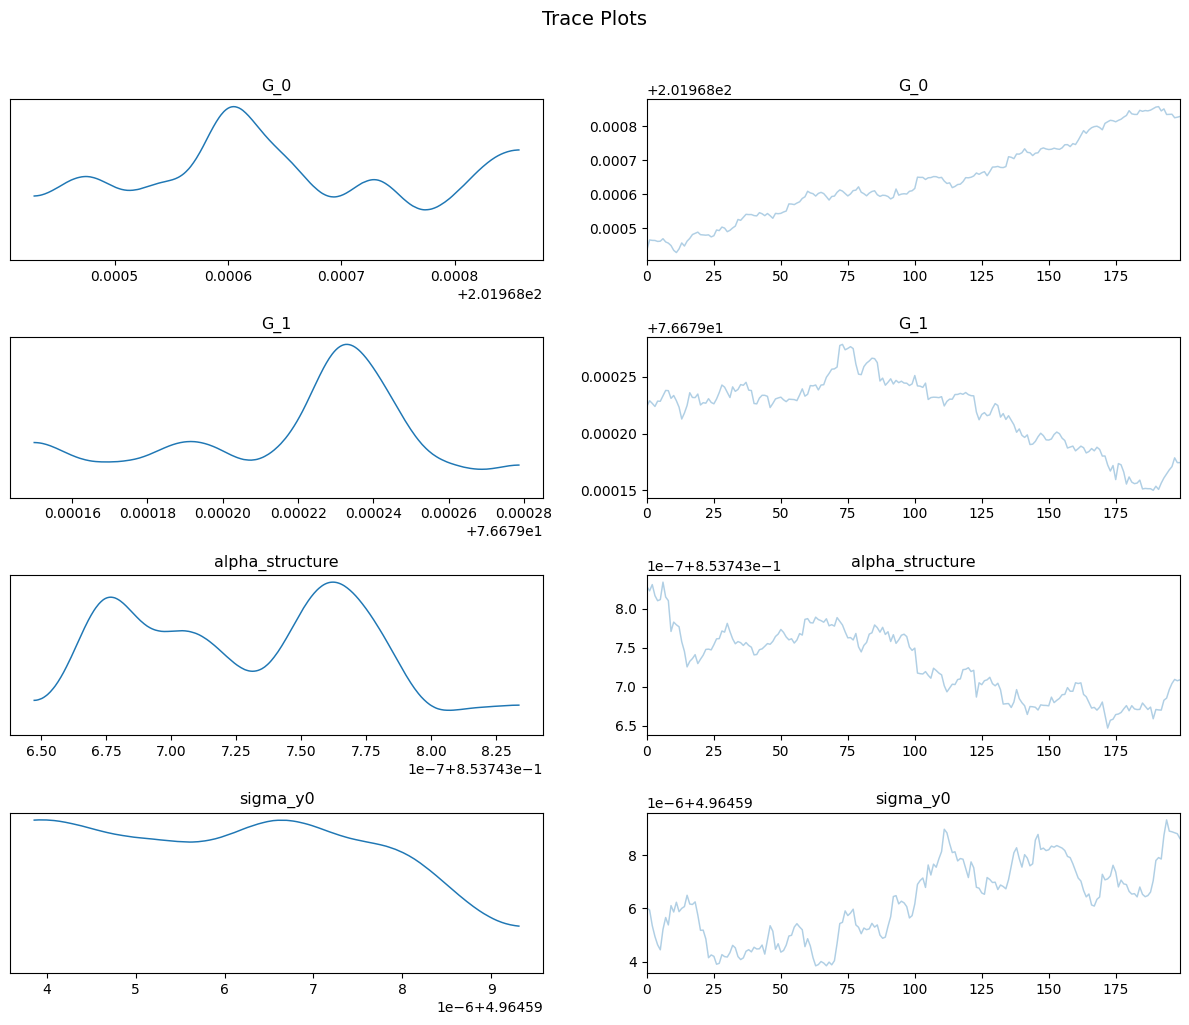

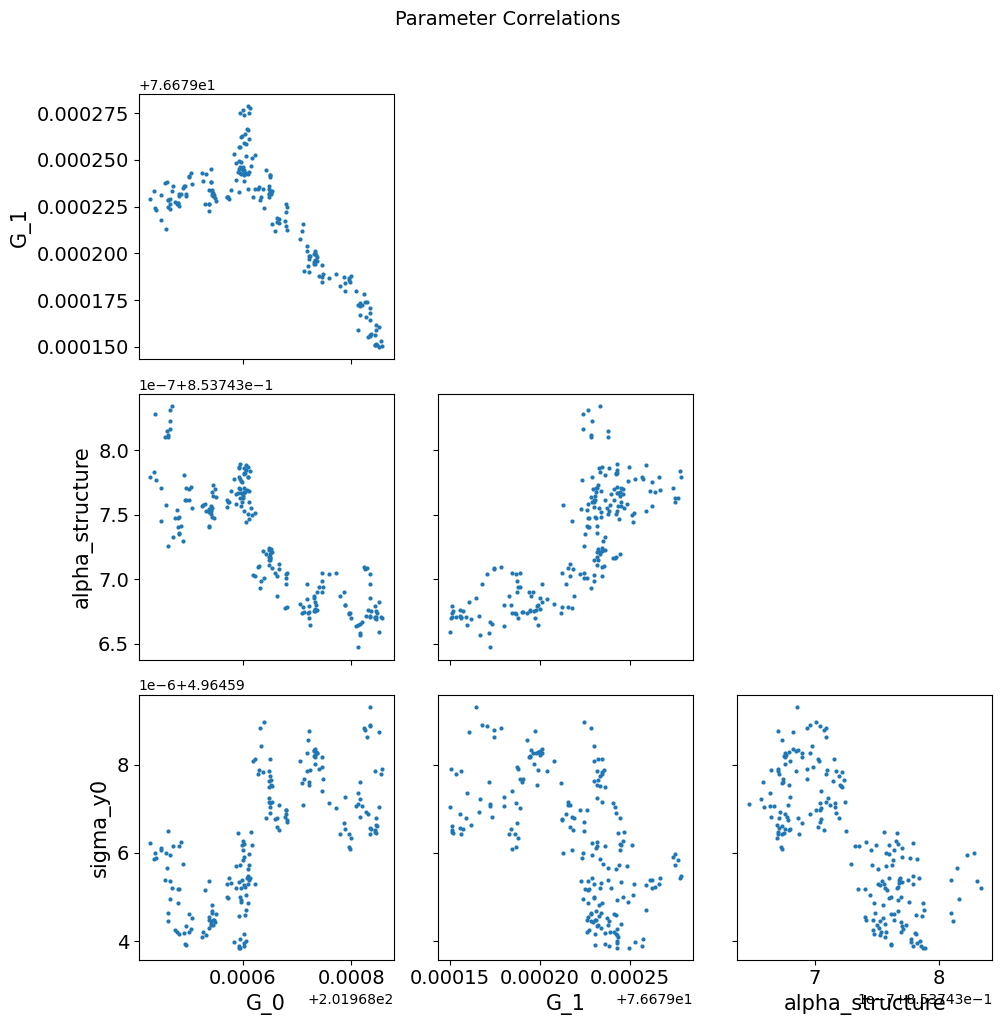

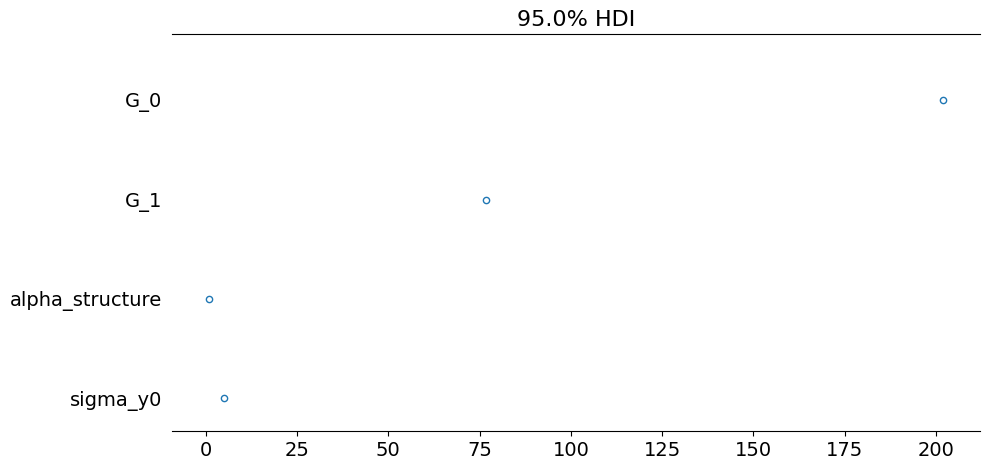

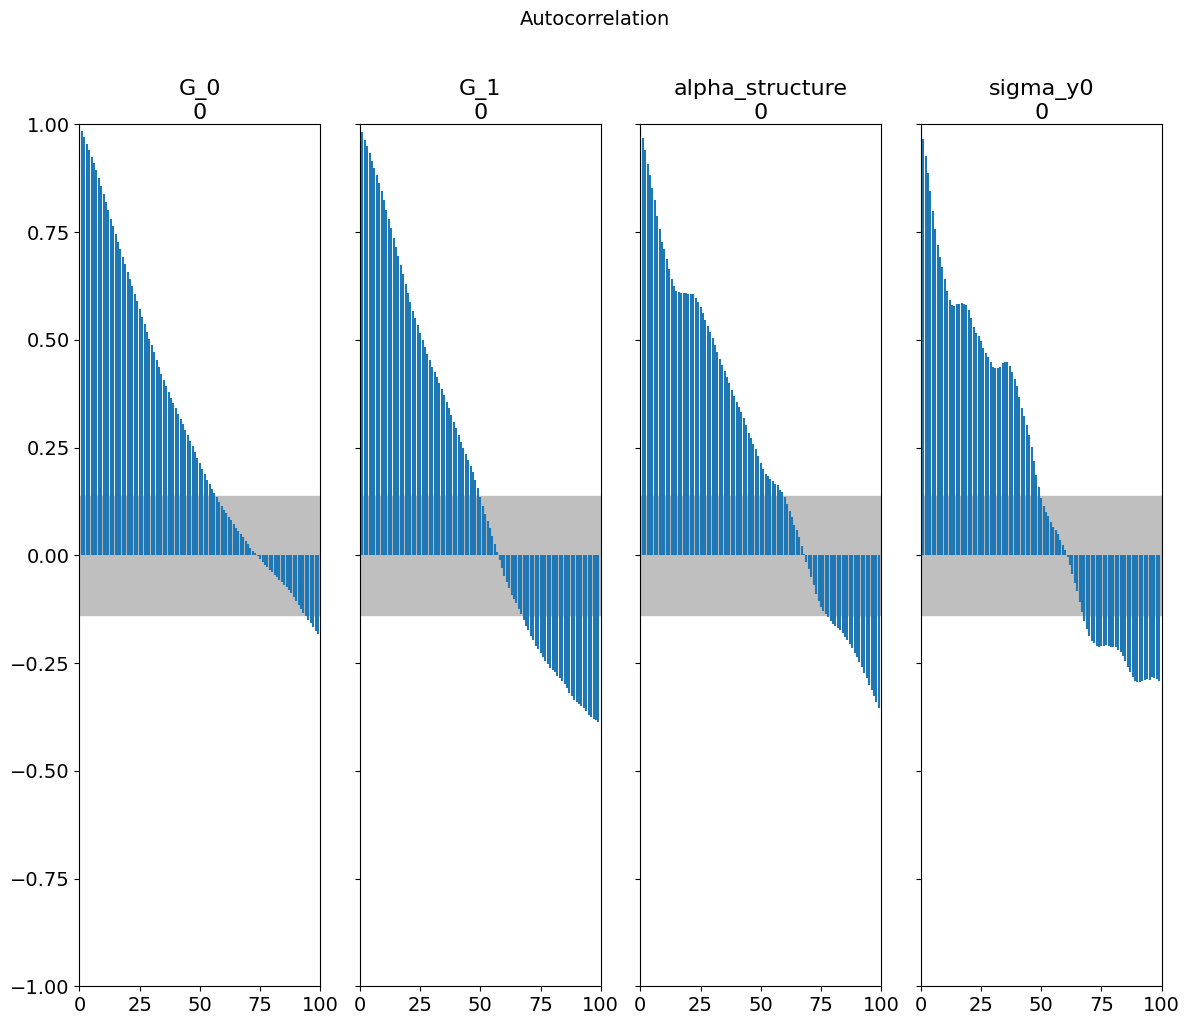

In [8]:
key_params = ["G_0", "G_1", "alpha_structure", "sigma_y0"]
print_convergence_summary(result, key_params)

print("\n### Diagnostic Interpretation")
print("| Metric | Target | Meaning |")
print("|--------|--------|---------|")
print("| **R-hat** | < 1.01 | Chain convergence |")
print("| **ESS** | > 400 | Sample quality |")
print("| **Divergences** | < 1% | NUTS reliability |")

display_arviz_diagnostics(result, key_params, fast_mode=FAST_MODE)

### Convergence Diagnostics

**Diagnostic Targets:**

| Metric | Target | Meaning |
|--------|--------|---------|
| **R-hat** | < 1.01 | Chain convergence |
| **ESS** | > 400 | Sample quality |
| **Divergences** | < 1% | NUTS reliability |

## 5. Save Results

In [9]:
save_fikh_results(model, result, "fmlikh", "laos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fmlikh/laos/
  nlsq_params_laos.json: 16 parameters
  posterior_laos.json: 200 draws


## 5. Save Results

## Key Takeaways

1. **FMLIKH LAOS: multi-mode yielding under oscillation**
2. **Distributed intra-cycle structure evolution** from each mode
3. **Complex Lissajous figures** with multiple yielding features
4. **Harmonics decay as $I_{n,i} \sim n^{-\alpha_i}$ per mode**
5. **Hierarchical structure produces rich nonlinear response**
6. **Residual analysis** of harmonics validates power-law decay per mode

---

## Further Reading

### RheoJAX Handbook

- **[FMLIKH Complete Guide](../../docs/source/models/fikh/fmlikh.rst)**: Multi-mode equations, mode selection, parameter estimation
- **[FIKH Model Family Overview](../../docs/source/models/fikh/index.rst)**: When to use FIKH vs FMLIKH, material recommendations
- **[Fractional Calculus in Rheology](../../docs/source/models/fikh/fikh.rst#theoretical-background)**: Caputo derivatives and Mittag-Leffler functions

### Key References

**Fractional Multi-Mode Theory:**
1. Wei, Y., Solomon, M.J., & Larson, R.G. (2018). "A multimode structural kinetics constitutive equation." *J. Rheol.*, 62(1), 321-342.
2. Jaishankar, A. & McKinley, G.H. (2014). "A fractional K-BKZ constitutive formulation." *J. Rheol.*, 58, 1751-1788.

**Fractional Calculus:**
3. Podlubny, I. (1999). *Fractional Differential Equations*. Academic Press.
4. Mainardi, F. (2010). *Fractional Calculus and Waves in Linear Viscoelasticity*. Imperial College Press.

**IKH Foundation:**
5. Dimitriou, C.J. & McKinley, G.H. (2014). "A comprehensive constitutive law for waxy crude oil." *Soft Matter*, 10, 6619-6644.
6. Geri, M. et al. (2017). "Thermokinematic memory and the thixotropic elasto-viscoplasticity of waxy crude oils." *J. Rheol.*, 61(3), 427-454.

---

### Next Steps

You've completed all **12 FIKH/FMLIKH tutorials**:

**FIKH (Single-Mode, NB01-06):**
- Flow curve, startup, relaxation, creep, SAOS, LAOS
- **Key signature**: Power-law memory via fractional derivative $D_t^{\alpha}$

**FMLIKH (Multi-Mode, NB07-12):**
- Same protocols with N=3 modes
- **Key signature**: Hierarchical relaxation + fractional memory per mode

### Applications

- **Waxy crude oils**: Pipeline restart, thermal cycling
- **Colloidal gels**: Hierarchical aggregation, aging
- **Drilling fluids**: Gel strength evolution, borehole stability
- **Food gels**: Texture recovery, processing windows
- **Greases**: Cold-start torque, shear stability